# Big Data Analytics – Final Project: Wetter vs. Stromverbrauch (Österreich)

**Team:** Gössl Marcel, Schrenk Dominik, Unger Miriam  
**Kurs:** Big Data Analytics  
**Repository:** https://github.com/Dom4i/BigData-WeatherEnergy

**Zeitraum der Analyse:** 01/2015 – 12/2019 (5 Jahre, stündliche Daten)

## Ziel & Fragestellung (Story)
In diesem Projekt kombinieren wir mehrere öffentliche Datenquellen (u.a. Wetterdaten und Stromverbrauchsdaten), um Einflüsse auf den **stündlichen Stromverbrauch** zu analysieren und daraus ein **einfaches Machine-Learning-Modell mit SparkML** zu trainieren.

**Leitfragen:**
- Welche Faktoren (Temperatur, Tageszeit, Wochentag, Feiertage, Saisonalität, …) beeinflussen den Stromverbrauch am stärksten?
- Wie gut lässt sich der Stromverbrauch aus diesen Features **vorhersagen**?

## Vorgehen 
1. **Data Source Layer:** Datensammlung über API + Webscraping + vorhandene Datasets  
2. **Raw Data Analysis:** Datenqualität prüfen, erste statistische Analysen und Visualisierungen  
3. **Processing Layer (Spark):** Bereinigung, Feature Engineering, Merging der Datensätze
4. **Machine Learning (SparkML):** Training, Evaluation und Interpretation  
5. **Data Output Layer:** Storytelling + Visualisierung der wichtigsten Erkenntnisse

## Erwartetes Ergebnis
- Ein bereinigter und gemergter **Feature-Datensatz (stündlich)**  
- Eine nachvollziehbare Analyse, welche Treiber den Verbrauch erklären  
- Ein SparkML-Modell mit Metriken (z.B. RMSE/MAE) und interpretierbaren Ergebnissen


## Abhängigkeiten
Die Python-Abhängigkeiten sind im `requirements.txt` dokumentiert.

Installation:
`pip install -r requirements.txt`

## Hier nochmal die wichtigsten Versionen der verwendeten Pakete:


In [1]:
import sys, platform, importlib

def v(pkg):
    try:
        return importlib.metadata.version(pkg)
    except Exception:
        return "n/a"

print("Python:", sys.version.split()[0])
print("OS:", platform.platform())
for pkg in ["pyspark", "pandas", "numpy", "matplotlib", "requests", "influxdb-client"]:
    print(f"{pkg:15} {v(pkg)}")


Python: 3.12.0
OS: Windows-11-10.0.26100-SP0
pyspark         4.1.1
pandas          2.3.3
numpy           2.3.5
matplotlib      n/a
requests        2.32.5
influxdb-client 1.49.0


# Big Data Kriterien (5Vs) – Einordnung unseres Projekts

Auch wenn unser Datensatz im Vergleich zu industriellen Big-Data-Systemen nicht extrem groß ist, orientiert sich unser Vorgehen an typischen Big-Data-Prozessen.

## Volume (Datenmenge)
Wir arbeiten mit **stündlichen Daten über 5 Jahre (01/2015–12/2019)**. Durch mehrere Datenquellen (Strom, Wetter, Kalender/Feiertage, Tageslicht) entsteht ein zusammengeführter Feature-Datensatz mit vielen Spalten.

## Velocity (Geschwindigkeit)
Die Daten werden zwar überwiegend als historische Daten verarbeitet (Batch), aber die verwendete Infrastruktur (API-Calls, NoSQL-Speicherung, Spark-Processing) ist auch für regelmäßig aktualisierte Daten geeignet.

## Variety (Vielfalt)
Wir nutzen mehrere Datenquellen und Formate:
- Stromverbrauch (CSV/Time-Series)
- Wetterdaten (API-basiert, teils pro Stadt)
- Kalender-/Feiertagsdaten (CSV)
- Tageslichtdaten (CSV/abgeleitete Tabellen)

## Veracity (Datenqualität)
Wir prüfen Datenqualität und Konsistenz (fehlende Werte, Ausreißer, Zeitstempel-Alignment, Einheiten) und dokumentieren Bereinigungsschritte, bevor die Daten gemerged werden.

## Value (Mehrwert)
Der Mehrwert entsteht durch:
- erklärende Analyse (welche Faktoren beeinflussen den Stromverbrauch?)
- Feature Engineering (z.B. Lags, Kalender-Features)
- ein SparkML-Modell zur **Vorhersage** des stündlichen Stromverbrauchs.


# Data Source Layer – Datensammlung & Rohdaten

In diesem Projekt verwenden wir mehrere Datenquellen. Die Rohdaten werden im Ordner `data/raw/` abgelegt und anschließend schrittweise bereinigt und zusammengeführt.


## 1. Stromverbrauch (stündlich, Europa) 
   - Quelle: Open Power System Data (OPSD) – Time Series Dataset  
   - Datenformat: CSV  
   - Hinweis: Download erfolgt manuell (kein API/Code notwendig).
   - Link: https://data.open-power-system-data.org/time_series/2020-10-06
   - wir verwenden "AT_load_actual_entsoe_transparency" als Zielvariable: Stromverbrauch wird stündlich als Mittelwert gespeichert z.B. 17:00 50000 MW verbraucht bedeutet, dass zwischen 17:00 und 18:00 Uhr im Schnitt 5000 MW verbraucht werden


##  2. Wetterdaten (stündlich) – Meteostat (RapidAPI)

Wir benötigen stündliche Wetterdaten für Österreich.  
Da ein flächendeckender Abruf für ganz Österreich mit einem einzelnen API-Key das Anfragelimit überschreiten würde, verwenden wir als praktikable Näherung die **9 Landeshauptstädte** und holen die Daten stündlich pro Stadt.
Zwar würde es in der Praxis mehr Sinn machen, mit Wettervorhersagen zu arbeiten (um den Stromverbrauch realistisch zu modellieren, da man in der Praxis immer nur Wettervorhersagen hat), wir konnten jedoch keine Wettervorhersagedaten (stündlich für 2015-2019) finden. Daher arbeiten wir mit tatsächlichen Wetterdaten (aus der Vergangenheit). Unser ML Modell wird also keine Ungenauigkeit durch ungenaue Wettervorhersagen beinhalten.

**Technische Umsetzung (API-Limit):**
- Abfrage wird **monatlich** gestartet (2015-01 bis 2019-12)
- Innerhalb eines Monats werden Daten zusätzlich in **~30-Tage-Chunks** geladen
- Es enststehen also pro Stadt 60 Files (5 Jahre x 12 Monate)
- Ergebnisse werden als CSV pro Monat gespeichert:
  - `data/raw/Wetterdata/<city>/<city>_YYYY_MM.csv`

> Hinweis: Wir dokumentieren den API-Code, führen ihn im Notebook aber standardmäßig nicht aus.


In [ ]:
# Meteostat RapidAPI Collection Script (Dokumentation) 
# Standardmäßig NICHT ausführen, um API Limits zu schonen:
RUN_API = False

import requests
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path
from dotenv import load_dotenv
import os

load_dotenv()

# CONFIG
cities = {
    "wien": (48.2082, 16.3738),
    "st_poelten": (48.2049, 15.6256),
    "linz": (48.3069, 14.2858),
    "salzburg": (47.8095, 13.0550),
    "graz": (47.0707, 15.4395),
    "klagenfurt": (46.6247, 14.3053),
    "innsbruck": (47.2692, 11.4041),
    "bregenz": (47.5031, 9.7471),
    "eisenstadt": (47.8456, 16.5233),
}

# Im Projekt wurde pro Stadt separat ausgeführt (wegen API Key Limit / Key-Wechsel)
CITY_NAME = "eisenstadt"
LAT = 47.8456
LON = 16.5233

START_DATE = "2015-01-01"
END_DATE = "2019-12-31"

API_KEY = os.getenv("")  

BASE_URL = "https://meteostat.p.rapidapi.com/point/hourly"
HEADERS = {
    "X-RapidAPI-Key": API_KEY,
    "X-RapidAPI-Host": "meteostat.p.rapidapi.com"
}

OUTPUT_DIR = Path("data/raw/Wetterdata") / CITY_NAME
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def month_start_dates(start, end):
    dates = []
    current = start.replace(day=1)
    while current <= end:
        dates.append(current)
        if current.month == 12:
            current = current.replace(year=current.year + 1, month=1)
        else:
            current = current.replace(month=current.month + 1)
    return dates

if RUN_API:
    start_dt = datetime.fromisoformat(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)

    for month_start in month_start_dates(start_dt, end_dt):
        # Monatsende bestimmen
        if month_start.month == 12:
            next_month = month_start.replace(year=month_start.year + 1, month=1)
        else:
            next_month = month_start.replace(month=month_start.month + 1)

        month_end = min(next_month - timedelta(days=1), end_dt)

        print(f"Lade {CITY_NAME} {month_start.strftime('%Y-%m')}")

        all_chunks = []
        chunk_start = month_start

        while chunk_start <= month_end:
            chunk_end = min(chunk_start + timedelta(days=29), month_end)

            params = {
                "lat": LAT,
                "lon": LON,
                "start": chunk_start.strftime("%Y-%m-%d"),
                "end": chunk_end.strftime("%Y-%m-%d")
            }

            response = requests.get(BASE_URL, headers=HEADERS, params=params)
            response.raise_for_status()

            data = response.json().get("data", [])
            if data:
                df_chunk = pd.DataFrame(data)
                all_chunks.append(df_chunk)

            chunk_start = chunk_end + timedelta(days=1)

        if all_chunks:
            df_month = pd.concat(all_chunks, ignore_index=True)
            df_month["time"] = pd.to_datetime(df_month["time"])

            filename = f"{CITY_NAME}_{month_start.year}_{month_start.month:02d}.csv"
            df_month.to_csv(OUTPUT_DIR / filename, index=False)

            print(f"Gespeichert: {filename} ({len(df_month)} Zeilen)")
        else:
            print(f"Keine Daten für {month_start.strftime('%Y-%m')}")

    print("Fertig!")
else:
    print("RUN_API=False → API Calls werden nicht ausgeführt (nur dokumentiert).")


# 3. Webscraping – Feiertage in Österreich (2015–2020)

Für Kalender- und Saisonalitäts-Features (z.B. *ist Feiertag?*) benötigen wir eine Liste der österreichischen Feiertage.
Da wir die Feiertage nicht aus einer fertigen API übernommen haben, nutzen wir Webscraping.

**Quelle:** ferienwiki.at (Jahresübersicht je Jahr)  
**Ziel:** Erstellen einer sauberen Feiertags-Tabelle (Datum + Name + Wochentag) als CSV in `data/raw/Feiertage/`.



In [2]:
# Webscraping: Feiertage Österreich 

import requests
from bs4 import BeautifulSoup
import pandas as pd
from pathlib import Path

BASE_URL = "https://www.ferienwiki.at/feiertage/{}/at"

raw_out = Path("data/raw/Feiertage/feiertage_at_2015_2020_raw.csv")
raw_out.parent.mkdir(parents=True, exist_ok=True)

data = []


for year in range(2015, 2021):
    print(f"Lade Daten für {year}...")
    url = BASE_URL.format(year)

    response = requests.get(url, timeout=30)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, "html.parser")

    table = soup.find("table", class_="table")
    if table is None:
        raise RuntimeError(f"Keine Tabelle gefunden für Jahr {year} ({url})")

    tbody = table.find("tbody")
    if tbody is None:
        raise RuntimeError(f"Kein <tbody> gefunden für Jahr {year} ({url})")

    for row in tbody.find_all("tr"):
        cols = row.find_all("td")
        if len(cols) != 4:
            continue

        name = cols[0].get_text(strip=True) or "Unbekannt"
        date_text = cols[1].get_text(strip=True)
        if not date_text:
            continue

        data.append({
            "year": year,
            "holiday_name": name,
            "date_raw": date_text
        })

df_raw = pd.DataFrame(data)
print("Rows:", len(df_raw))
df_raw.to_csv(raw_out, index=False)
print("Gespeichert:", raw_out)



Lade Daten für 2015...
Lade Daten für 2016...
Lade Daten für 2017...
Lade Daten für 2018...
Lade Daten für 2019...
Lade Daten für 2020...
Rows: 81
Gespeichert: data\raw\Feiertage\feiertage_at_2015_2020_raw.csv


# 4. Tageslicht (Sunrise/Sunset) als Feature

Für Stromverbrauch ist Tageslicht bzw. die Länge des Tages oft ein relevanter Einflussfaktor (Saisonalität).
Statt nur “Monat” zu verwenden, erzeugen wir ein genaueres Feature basierend auf **Sonnenaufgang/-untergang**.

## Vorgehen
1. **Geocoding der Landeshauptstädte** (Latitude/Longitude) über Nominatim (OpenStreetMap)  
2. **Berechnung von Sonnenaufgang und Sonnenuntergang** pro Tag und Stadt mit `astral`  
3. **Durchschnitt über Österreich** als Mittelwert über die Landeshauptstädte  
4. Speicherung als tägliche CSV in `data/raw/Tageslicht/`



In [3]:
from geopy.geocoders import Nominatim
import time
import json
from pathlib import Path

CITIES = [
    "Bregenz",
    "Innsbruck",
    "Salzburg",
    "Linz",
    "Wien",
    "Graz",
    "Klagenfurt"
]

out_json = Path("data/util/austria_places_latlon.json")
out_json.parent.mkdir(parents=True, exist_ok=True)

geolocator = Nominatim(user_agent="austria-daylight-analysis")

def geocode_city(city: str):
    location = geolocator.geocode(f"{city}, Austria")
    if location is None:
        raise ValueError(f"Ort nicht gefunden: {city}")
    return {"latitude": round(location.latitude, 6), "longitude": round(location.longitude, 6)}

places = {}
for city in CITIES:
    print(f"Geocoding {city} ...")
    places[city] = geocode_city(city)
    time.sleep(1)  # Rate-Limit beachten

with open(out_json, "w", encoding="utf-8") as f:
    json.dump(places, f, indent=2, ensure_ascii=False)

print("Koordinaten gespeichert:", out_json)


Geocoding Bregenz ...
Geocoding Innsbruck ...
Geocoding Salzburg ...
Geocoding Linz ...
Geocoding Wien ...
Geocoding Graz ...
Geocoding Klagenfurt ...
Koordinaten gespeichert: data\util\austria_places_latlon.json


In [4]:
from datetime import date, datetime, timedelta
from zoneinfo import ZoneInfo
from astral import LocationInfo
from astral.sun import sun
import csv
import json
import statistics
from pathlib import Path

TZ = ZoneInfo("Europe/Vienna")

places_file = Path("data/util/austria_places_latlon.json")
with open(places_file, encoding="utf-8") as f:
    PLACES = json.load(f)

def seconds_since_midnight(dt: datetime) -> int:
    return dt.hour * 3600 + dt.minute * 60 + dt.second

def hhmmss_from_seconds(sec: int) -> str:
    sec = int(round(sec)) % 86400
    h = sec // 3600
    m = (sec % 3600) // 60
    s = sec % 60
    return f"{h:02d}:{m:02d}:{s:02d}"

def sunrise_sunset_for_place(lat: float, lon: float, d: date):
    loc = LocationInfo("x", "AT", "Europe/Vienna", lat, lon)
    s = sun(loc.observer, date=d, tzinfo=TZ)
    return s["sunrise"], s["sunset"]

def austria_avg_sunrise_sunset(d: date):
    sunrise_secs, sunset_secs = [], []
    for coords in PLACES.values():
        sr, ss = sunrise_sunset_for_place(coords["latitude"], coords["longitude"], d)
        sunrise_secs.append(seconds_since_midnight(sr))
        sunset_secs.append(seconds_since_midnight(ss))
    return int(round(statistics.mean(sunrise_secs))), int(round(statistics.mean(sunset_secs)))

def daterange(start: date, end: date):
    cur = start
    while cur <= end:
        yield cur
        cur += timedelta(days=1)

START_DATE = "2015-01-01"
END_DATE = "2019-12-31"
start = date.fromisoformat(START_DATE)
end = date.fromisoformat(END_DATE)

out_csv = Path("data/raw/Tageslicht/austria_sunrise_sunset_avg_last5y_daily.csv")
out_csv.parent.mkdir(parents=True, exist_ok=True)

with open(out_csv, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["date", "sunrise_avg", "sunset_avg", "sunrise_avg_seconds", "sunset_avg_seconds"])
    for d in daterange(start, end):
        sr_sec, ss_sec = austria_avg_sunrise_sunset(d)
        w.writerow([d.isoformat(), hhmmss_from_seconds(sr_sec), hhmmss_from_seconds(ss_sec), sr_sec, ss_sec])

print("Tageslicht CSV gespeichert:", out_csv)


Tageslicht CSV gespeichert: data\raw\Tageslicht\austria_sunrise_sunset_avg_last5y_daily.csv


# Kurzer Rohdaten-Check (alle 4 Quellen)

Wir prüfen, ob die Rohdaten-Dateien vorhanden sind und zeigen pro Quelle ein paar Beispielzeilen.


In [5]:
from pathlib import Path
import pandas as pd
import glob

# 1) Strom (OPSD) – nur ein paar Zeilen laden (große Datei)
energy_path = Path("data/raw/Strom/time_series_60min_singleindex.csv")
print("1) Energy exists:", energy_path.exists(), "|", energy_path)

if energy_path.exists():
    df_energy_preview = pd.read_csv(energy_path, nrows=5)
    display(df_energy_preview)

# 2) Wetter (Meteostat) – irgendeine vorhandene Monatsdatei automatisch finden
weather_root = Path("data/raw/Wetterdata")
weather_files = sorted(glob.glob(str(weather_root / "*" / "*.csv")))
print("\n2) Weather folder exists:", weather_root.exists(), "| files found:", len(weather_files))

if weather_files:
    sample_weather = Path(weather_files[0])
    print("Sample weather file:", sample_weather)
    df_weather_preview = pd.read_csv(sample_weather, nrows=5)
    display(df_weather_preview)

# 3) Feiertage – clean CSV
holidays_path = Path("data/raw/Feiertage/feiertage_at_2015_2020_clean.csv")
print("\n3) Holidays exists:", holidays_path.exists(), "|", holidays_path)

if holidays_path.exists():
    df_holidays_preview = pd.read_csv(holidays_path, nrows=10)
    display(df_holidays_preview)

# 4) Tageslicht – daily CSV
daylight_path = Path("data/raw/Tageslicht/austria_sunrise_sunset_avg_last5y_daily.csv")
print("\n4) Daylight exists:", daylight_path.exists(), "|", daylight_path)

if daylight_path.exists():
    df_daylight_preview = pd.read_csv(daylight_path, nrows=10)
    display(df_daylight_preview)


1) Energy exists: True | data\raw\Strom\time_series_60min_singleindex.csv


,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
0,2014-12-31T23:00:00Z,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01T00:00:00Z,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01T01:00:00Z,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN
3,2015-01-01T02:00:00Z,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,...,1004.79,805.0,NaN,1.04,2626.0,2810.0,3.8,NaN,NaN,NaN
4,2015-01-01T03:00:00Z,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,...,983.79,803.0,NaN,1.61,2618.0,2780.0,3.8,NaN,NaN,NaN



2) Weather folder exists: True | files found: 540
Sample weather file: data\raw\Wetterdata\Linz\Linz_2015_01.csv


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2015-01-01 00:00:00,-2.2,-3.0,94.0,0.1,NaN,NaN,7.2,NaN,1037.9,NaN,NaN
1,2015-01-01 01:00:00,NaN,NaN,NaN,0.0,NaN,310.0,3.6,NaN,NaN,NaN,NaN
2,2015-01-01 02:00:00,0.0,-2.1,86.0,0.1,NaN,260.0,11.2,NaN,NaN,NaN,NaN
3,2015-01-01 03:00:00,-0.8,-1.9,92.0,0.0,NaN,260.0,10.8,NaN,1037.8,NaN,NaN
4,2015-01-01 04:00:00,-1.0,-2.0,93.0,0.0,NaN,260.0,13.0,NaN,NaN,NaN,NaN



3) Holidays exists: True | data\raw\Feiertage\feiertage_at_2015_2020_clean.csv


,year,month,day,date,weekday,holiday_name
0,2015,1,1,2015-01-01,Donnerstag,Neujahr
1,2015,1,6,2015-01-06,Dienstag,Heilige Drei Könige
2,2015,4,6,2015-04-06,Montag,Ostermontag
3,2015,5,1,2015-05-01,Freitag,Staatsfeiertag
4,2015,5,14,2015-05-14,Donnerstag,Christi Himmelfahrt
5,2015,5,25,2015-05-25,Montag,Pfingstmontag
6,2015,6,4,2015-06-04,Donnerstag,Fronleichnam
7,2015,8,15,2015-08-15,Samstag,Mariä Himmelfahrt
8,2015,10,26,2015-10-26,Montag,Nationalfeiertag
9,2015,11,1,2015-11-01,Sonntag,Allerheiligen



4) Daylight exists: True | data\raw\Tageslicht\austria_sunrise_sunset_avg_last5y_daily.csv


,date,sunrise_avg,sunset_avg,sunrise_avg_seconds,sunset_avg_seconds
0,2015-01-01,07:54:15,16:24:38,28455,59078
1,2015-01-02,07:54:15,16:25:35,28455,59135
2,2015-01-03,07:54:11,16:26:35,28451,59195
3,2015-01-04,07:54:05,16:27:38,28445,59258
4,2015-01-05,07:53:55,16:28:42,28435,59322
5,2015-01-06,07:53:44,16:29:48,28424,59388
6,2015-01-07,07:53:28,16:30:56,28408,59456
7,2015-01-08,07:53:11,16:32:06,28391,59526
8,2015-01-09,07:52:50,16:33:18,28370,59598
9,2015-01-10,07:52:27,16:34:31,28347,59671


# Raw Data Analysis (RDA)

Bevor wir Daten verarbeiten und Features bauen, prüfen wir die Rohdaten auf:
- Struktur  (stündlich/täglich)
- Vollständigkeit (Missing Values)
- potenziell unnötige Spalten / redundante Informationen
- Plausibilität und grobe Ausreißer

Ziel dieser Analyse ist es, Entscheidungen für das spätere Data Processing abzuleiten,
z.B. welche Spalten wir verwenden, welche wir entfernen und welche Daten wir zusammenführen.
Ein Teil der Prüfung erfolgte auch manuell durch Sichtung der Tabellen (z.B. Auswahl von Österreich-Spalten bei Stromdaten).


## 1. Raw Data Analysis – Stromdaten (OPSD, Österreich)

In den Stromdaten sind viele Länder enthalten. Für unser Projekt fokussieren wir auf Österreich und prüfen:
- Vollständigkeit der relevanten AT-Spalten
- Richtigkeit der Zeitstempel
- Plausible Wertebereiche (keine negativen Last-/Erzeugungswerte)
- erste statistische Kennzahlen und Korrelationen

Diese Analyse dient als Grundlage für das spätere Data Processing 


In [7]:
import pandas as pd

# Analyse Stromdaten in AT

# Pfad zur Datei
file_path = "data/raw/Strom/time_series_60min_singleindex.csv"

# CSV-Datei einlesen
df = pd.read_csv(file_path)

print("Vorschau der Rohdaten:")
print(df.head(), "\n")

# Auswahl der relevanten Spalten (AT)
# Nur österreichische Werte verwendet
at_columns = [
    "utc_timestamp",
    "cet_cest_timestamp",
    "AT_load_actual_entsoe_transparency",
    "AT_load_forecast_entsoe_transparency",
    "AT_price_day_ahead",
    "AT_solar_generation_actual",
    "AT_wind_onshore_generation_actual"
]

df_at = df[at_columns].copy()

print("Vorschau der AT-Daten:")
print(df_at.head(), "\n")

# Vollständigkeit
# Überprüfung auf fehlende Werte
print("Fehlende Werte pro AT-Spalte:")
print(df_at.isnull().sum(), "\n")

# Datumsrichtigkeit
# Umwandlung der Zeitstempel in Datumsformt
df_at["utc_timestamp"] = pd.to_datetime(
    df_at["utc_timestamp"], errors="coerce"
)

df_at["cet_cest_timestamp"] = pd.to_datetime(
    df_at["cet_cest_timestamp"], errors="coerce"
)

# Überprüfung auf ungültige Zeitstempel
print("Ungültige UTC-Zeitstempel:")
print(df_at[df_at["utc_timestamp"].isnull()], "\n")

print("Ungültige CET/CEST-Zeitstempel:")
print(df_at[df_at["cet_cest_timestamp"].isnull()], "\n")

# Wertebereiche
# Überprüfung auf negative oder unrealistische Werte
print("Negative Lastwerte (AT_load_actual):")
print(df_at[df_at["AT_load_actual_entsoe_transparency"] < 0], "\n")

print("Negative Erzeugungswerte (Solar / Wind):")
print(
    df_at[
        (df_at["AT_solar_generation_actual"] < 0) |
        (df_at["AT_wind_onshore_generation_actual"] < 0)
    ],
    "\n"
)

# Statistische Analyse
# Wichtigsten numerischen Spalten
print("Deskriptive Statistik der AT-Stromdaten:")
print(
    df_at[
        [
            "AT_load_actual_entsoe_transparency",
            "AT_load_forecast_entsoe_transparency",
            "AT_price_day_ahead",
            "AT_solar_generation_actual",
            "AT_wind_onshore_generation_actual"
        ]
    ].describe(),
    "\n"
)

# Analyse von Abweichungen
# Differenz zwischen tatsächlicher und prognostizierter Last
df_at["load_difference"] = (
    df_at["AT_load_actual_entsoe_transparency"]
    - df_at["AT_load_forecast_entsoe_transparency"]
)

print("Abweichung zwischen Ist- und Prognoselast:")
print(df_at["load_difference"].describe(), "\n")


# Korrelationen
# Zusammenhängen zwischen Last, Preis und Erzeugung???
correlation_matrix = df_at[
    [
        "AT_load_actual_entsoe_transparency",
        "AT_price_day_ahead",
        "AT_solar_generation_actual",
        "AT_wind_onshore_generation_actual"
    ]
].corr()

print("Korrelationsmatrix (AT-Daten):")
print(correlation_matrix, "\n")


Vorschau der Rohdaten:
          utc_timestamp        cet_cest_timestamp  \
0  2014-12-31T23:00:00Z  2015-01-01T00:00:00+0100   
1  2015-01-01T00:00:00Z  2015-01-01T01:00:00+0100   
2  2015-01-01T01:00:00Z  2015-01-01T02:00:00+0100   
3  2015-01-01T02:00:00Z  2015-01-01T03:00:00+0100   
4  2015-01-01T03:00:00Z  2015-01-01T04:00:00+0100   

   AT_load_actual_entsoe_transparency  AT_load_forecast_entsoe_transparency  \
0                                 NaN                                   NaN   
1                              5946.0                                6701.0   
2                              5726.0                                6593.0   
3                              5347.0                                6482.0   
4                              5249.0                                6454.0   

   AT_price_day_ahead  AT_solar_generation_actual  \
0                 NaN                         NaN   
1                35.0                         NaN   
2                45.0   

C:\Users\Dominik\AppData\Local\Temp\ipykernel_5588\2098089143.py:42: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_at["cet_cest_timestamp"] = pd.to_datetime(


## Ergebnis: Die AT-Stromdaten sind bei utc_timestamp sowie Load/Solar/Wind nahezu vollständig (nur sehr wenige Missing), während AT_price_day_ahead viele fehlende Werte hat, weshalb wir im weiteren Processing auf utc_timestamp, load_mw, solar_mw und wind_mw fokussieren und den Preis weglassen.

## 2.  Raw Data Analysis – Wetterdaten (Meteostat, stündlich)

Die Wetterdaten liegen als Monats-CSV pro Stadt (Ordnerstruktur) vor.
Für die Analyse werden alle Dateien eingelesen, zusammengeführt und auf Datenqualität geprüft:
- Vollständigkeit je Feature
- gültige Zeitstempel und Duplikate pro Stadt
- Plausible Wertebereiche (Temp, Feuchte, Niederschlag, Wind, Druck)
- einfache Statistiken und Korrelationen

Die Ergebnisse dieser Analyse werden später im Processing genutzt (Feature-Auswahl, Cleaning, Merge-Strategie).


In [8]:
import pandas as pd
from pathlib import Path

# Wetterdaten-Analyse Österreich

base_path = Path("data/raw/Wetterdata")

all_data = []

for city_dir in base_path.iterdir():
    if city_dir.is_dir():
        city = city_dir.name  # Stadtname aus Ordner weil unterschiedlich geschrieben

        for file in city_dir.glob("*.csv"):
            try:
                # Dateiname
                filename_parts = file.stem.split("_")
                year = int(filename_parts[-2])
                month = int(filename_parts[-1])

                # CSV-Datei einlesen
                df = pd.read_csv(file)

                # Zusatzinformationen ergänzen
                df["city"] = city
                df["year"] = year
                df["month"] = month

                # Zeitstempel konvertieren
                df["time"] = pd.to_datetime(df["time"], errors="coerce")

                all_data.append(df)

            except Exception as e:
                print(f"Fehler beim Einlesen von {file.name}: {e}")

# Alle Wetterdaten zusammenführen
weather_df = pd.concat(all_data, ignore_index=True)

print("Vorschau der zusammengeführten Wetterdaten:")
print(weather_df.head(), "\n")

# Vollständigkeit
print("Fehlende Werte pro Spalte:")
print(weather_df.isnull().sum(), "\n")

print("Anzahl Datensätze insgesamt:", len(weather_df))
print("Anzahl Städte:", weather_df["city"].nunique(), "\n")

# Zeitstempel
print("Ungültige Zeitstempel:")
print(weather_df[weather_df["time"].isnull()], "\n")

# Doppelte Zeitstempel pro Stadt prüfen
duplicates = weather_df.duplicated(subset=["city", "time"])
print("Anzahl doppelter Zeitstempel:", duplicates.sum(), "\n")

# Realistische Werte
# Realistische Wertebereiche
invalid_temp = weather_df[(weather_df["temp"] < -30) | (weather_df["temp"] > 45)]
invalid_rhum = weather_df[(weather_df["rhum"] < 0) | (weather_df["rhum"] > 100)]
invalid_prcp = weather_df[weather_df["prcp"] < 0]
invalid_wind = weather_df[weather_df["wspd"] < 0]
invalid_pressure = weather_df[
    (weather_df["pres"].notnull()) &
    ((weather_df["pres"] < 850) | (weather_df["pres"] > 1100))
]

print("Unplausible Temperaturwerte:", len(invalid_temp))
print("Unplausible Luftfeuchtewerte:", len(invalid_rhum))
print("Negative Niederschlagswerte:", len(invalid_prcp))
print("Negative Windgeschwindigkeiten:", len(invalid_wind))
print("Unplausible Luftdruckwerte:", len(invalid_pressure), "\n")

# Statistische Analyse
print("Deskriptive Statistik (Temperatur, Feuchte, Wind, Luftdruck):")
print(
    weather_df[["temp", "rhum", "wspd", "pres"]].describe(),
    "\n"
)

# Durchschnittstemperatur pro Stadt
avg_temp_city = weather_df.groupby("city")["temp"].mean().sort_values()
print("Durchschnittstemperatur pro Stadt:")
print(avg_temp_city, "\n")

# Korrelationen
correlation_matrix = weather_df[
    ["temp", "rhum", "wspd", "pres"]
].corr()

print("Korrelationsmatrix:")
print(correlation_matrix, "\n")


Vorschau der zusammengeführten Wetterdaten:
                 time  temp  dwpt  rhum  prcp  snow  wdir  wspd  wpgt    pres  \
0 2015-01-01 00:00:00  -6.6  -7.0  97.0   0.0   NaN  30.0  14.0   NaN     NaN   
1 2015-01-01 01:00:00  -6.9  -7.3  97.0   0.0   NaN  30.0  13.3   NaN     NaN   
2 2015-01-01 02:00:00  -8.9  -9.7  94.0   0.0   NaN  30.0  10.1   NaN     NaN   
3 2015-01-01 03:00:00  -9.4 -10.2  94.0   0.0   NaN   0.0   8.6   NaN  1038.8   
4 2015-01-01 04:00:00  -9.0  -9.7  95.0   0.0   NaN  50.0  11.2   NaN     NaN   

   tsun  coco     city  year  month  
0   NaN   NaN  bregenz  2015      1  
1   NaN   NaN  bregenz  2015      1  
2   NaN   NaN  bregenz  2015      1  
3   0.0   NaN  bregenz  2015      1  
4   0.0   NaN  bregenz  2015      1   

Fehlende Werte pro Spalte:
time          0
temp        180
dwpt        187
rhum        187
prcp     131444
snow     383012
wdir      18013
wspd        508
wpgt     274031
pres      38502
tsun     232293
coco     211153
city          0
year

## Ergebnis: Die Wetterdaten sind insgesamt gut nutzbar, jedoch sind mehrere Spalten stark unvollständig (u.a. snow, wpgt, tsun, coco und teilweise prcp), weshalb wir uns im weiteren Processing auf die weitgehend vollständigen Kernfeatures wie temp, rhum, wspd (und optional pres) konzentrieren.

## 4. Raw Data Analysis – Feiertage (AT, Webscraping)

Die Feiertage wurden per Webscraping gesammelt. In dieser Analyse prüfen wir grob:
- Vollständigkeit der Rohdaten
- ob das Datum korrekt extrahiert werden kann
- Plausibilität des Wochentags (angegeben vs. aus Datum berechnet)

Diese Daten werden später im Processing zu stündlichen Kalender-Features (z.B. `is_holiday`) umgewandelt.


In [9]:
import pandas as pd

# Analyse von Feiertagen und Wochentagen
# ist aber Webscraping also sollte alles passen
# und ich muss sagen ich hab bisschen was unnötiges da drinnen auch gemacht haha

# Pfad
file_path = "data/raw/Feiertage/feiertage_at_2015_2020_raw.csv"

# CSV-Datei einlesen
df = pd.read_csv(file_path)

print("Vorschau der Rohdaten:")
print(df.head(), "\n")

# Vollständigkeit
# fehlende Werte pro Spalte
print("Fehlende Werte pro Spalte:")
print(df.isnull().sum(), "\n")

# Trennung von Datum und Wochentag
# Extraktion des Datums in TT.MM.YYYY
df["date_str"] = df["date_raw"].str.extract(r"(\d{2}\.\d{2}\.\d{4})")

df["weekday_text"] = df["date_raw"].str.extract(r"\((.*?)\)")

# Umwandlung in ein echtes Datumsformat
df["date"] = pd.to_datetime(
    df["date_str"],
    format="%d.%m.%Y",
    errors="coerce"
)

# Ausgabe von Zeilen mit ungültigen Wert
print("Zeilen mit ungültigen Datumswerten:")
print(df[df["date"].isnull()], "\n")

# Berechnung des Wochentags aus dem Datum (schauen ob das stimmt)
# Mapping englischen auf deutsche
weekday_map = {
    "Monday": "Montag",
    "Tuesday": "Dienstag",
    "Wednesday": "Mittwoch",
    "Thursday": "Donnerstag",
    "Friday": "Freitag",
    "Saturday": "Samstag",
    "Sunday": "Sonntag"
}

# Berechnung des Wochentags aus Datum
df["weekday_calc"] = df["date"].dt.day_name().map(weekday_map)

# Vergleich zwischen angegebenem und berechnetem Wochentag
df["weekday_match"] = df["weekday_text"] == df["weekday_calc"]

print("Anzahl inkorrekter Wochentagsangaben:")
print((~df["weekday_match"]).sum(), "\n")

# Statistische Analyse

# Anzahl der Feiertage pro Jahr
holidays_per_year = df.groupby("year").size()
print("Anzahl der Feiertage pro Jahr:")
print(holidays_per_year, "\n")

# Verteilung der Feiertage nach Wochentagen
weekday_distribution = df["weekday_calc"].value_counts()
print("Verteilung der Feiertage nach Wochentagen:")
print(weekday_distribution, "\n")

# Häufigste Feiertage
most_common_holidays = df["holiday_name"].value_counts().head(10)
print("Häufigste Feiertage:")
print(most_common_holidays, "\n")

# Zusammenfassende Statistik

print("Zusammenfassende Statistik:")
print(holidays_per_year.describe(), "\n")


Vorschau der Rohdaten:
   year         holiday_name                 date_raw
0  2015              Neujahr  01.01.2015 (Donnerstag)
1  2015  Heilige Drei Könige    06.01.2015 (Dienstag)
2  2015          Ostermontag      06.04.2015 (Montag)
3  2015       Staatsfeiertag     01.05.2015 (Freitag)
4  2015  Christi Himmelfahrt  14.05.2015 (Donnerstag) 

Fehlende Werte pro Spalte:
year            0
holiday_name    0
date_raw        0
dtype: int64 

Zeilen mit ungültigen Datumswerten:
Empty DataFrame
Columns: [year, holiday_name, date_raw, date_str, weekday_text, date]
Index: [] 

Anzahl inkorrekter Wochentagsangaben:
0 

Anzahl der Feiertage pro Jahr:
year
2015    12
2016    12
2017    12
2018    15
2019    15
2020    15
dtype: int64 

Verteilung der Feiertage nach Wochentagen:
weekday_calc
Montag        19
Donnerstag    18
Sonntag       12
Dienstag       9
Freitag        8
Mittwoch       8
Samstag        7
Name: count, dtype: int64 

Häufigste Feiertage:
holiday_name
Neujahr                6


## Ergebnis: Die Feiertagsdaten sind vollständig und konsistent (keine fehlenden Werte, keine ungültigen Datumswerte und 0 falsche Wochentage), daher können wir sie direkt als zuverlässige Basis für das spätere is_holiday-Feature verwenden.

## 4. Raw Data Analysis – Tageslicht (Wien, monatlich)

Als erste Orientierung wurde zu Beginn eine monatliche Tageslänge für Wien analysiert.
Damit prüfen wir Vollständigkeit, Format/Plausibilität und bekommen ein Gefühl für die saisonale Abhängigkeit.

> Hinweis: Später wurde das Feature durch eine genauere tägliche Berechnung (Sunrise/Sunset, Österreich-Durchschnitt) ersetzt.


In [6]:
import pandas as pd

# Analyse der monatlichen Sonnenlänge in Wien

file_path = "data/raw/Tageslicht/sonnenlaenge_wien_monatlich.csv"

df = pd.read_csv(file_path)

print("Vorschau der Rohdaten:")
print(df, "\n")

# Vollständigkeit
print("Fehlende Werte pro Spalte:")
print(df.isnull().sum(), "\n")

# Überprüfung, ob alle 12 Monate vorhanden sind
print("Anzahl der Monate im Datensatz:")
print(len(df), "\n")

# Richtigkeit des Zeitformats
# Auftrennen der Tageslänge in hh:mm
time_split = df["day_length"].str.split(":", expand=True)

df["hours"] = pd.to_numeric(time_split[0], errors="coerce")
df["minutes"] = pd.to_numeric(time_split[1], errors="coerce")

# Umrechnung der Tageslänge in Minuten
df["day_length_minutes"] = df["hours"] * 60 + df["minutes"]

print("Ungültige Zeitangaben:")
print(df[df["day_length_minutes"].isnull()], "\n")

# Plausibilität?? (0–1440 Minuten)
print("Unplausible Tageslängen:")
print(df[(df["day_length_minutes"] < 0) | (df["day_length_minutes"] > 1440)], "\n")

# Statistische Analyse
print("Deskriptive Statistik der Tageslänge (Minuten):")
print(df["day_length_minutes"].describe(), "\n")

# Monat mit längstem und kürzestem Tag
max_day = df.loc[df["day_length_minutes"].idxmax()]
min_day = df.loc[df["day_length_minutes"].idxmin()]

print("Monat mit längster Tageslänge:")
print(max_day[["month", "day_length"]], "\n")

print("Monat mit kürzester Tageslänge:")
print(min_day[["month", "day_length"]], "\n")

# Abhängigkeit

df["month_index"] = range(1, len(df) + 1)

correlation = df["month_index"].corr(df["day_length_minutes"])
print("Korrelation zwischen Monatsindex und Tageslänge:")
print(correlation, "\n")


Vorschau der Rohdaten:
        month day_length
0      Jänner       8:52
1     Februar      10:19
2        März      11:56
3       April      13:44
4         Mai      15:16
5        Juni      16:07
6        Juli      15:44
7      August      14:23
8   September      12:39
9     Oktober      10:55
10   November       9:18
11   Dezember       8:26 

Fehlende Werte pro Spalte:
month         0
day_length    0
dtype: int64 

Anzahl der Monate im Datensatz:
12 

Ungültige Zeitangaben:
Empty DataFrame
Columns: [month, day_length, hours, minutes, day_length_minutes]
Index: [] 

Unplausible Tageslängen:
Empty DataFrame
Columns: [month, day_length, hours, minutes, day_length_minutes]
Index: [] 

Deskriptive Statistik der Tageslänge (Minuten):
count     12.000000
mean     738.250000
std      165.204075
min      506.000000
25%      603.750000
50%      737.500000
75%      876.250000
max      967.000000
Name: day_length_minutes, dtype: float64 

Monat mit längster Tageslänge:
month          Juni
day

## Ergebnis: Wir sind draufgekommen dass die monatliche Tageslänge zu ungenau ist und haben danach die genauere tägliche Berechnung für ganz Österreich umgesetzt (diese jedoch nichtmehr in der data analysis gemacht.)

# Data Processing (Raw → Processed)

Ziel der Verarbeitung ist es, alle Datenquellen auf ein **einheitliches Zeitformat (UTC, stündlich)** zu bringen,
unnötige Spalten zu entfernen und die Datensätze so vorzubereiten, dass sie anschließend gemerged und auch in  InfluxDB gespeichert werden können.

## 1. Stromdaten (OPSD) – Raw → Processed
In diesem Schritt:
- lesen wir die große OPSD-Zeitreihen-CSV ein,
- filtern auf Österreich und die benötigten Features,
- parsen den Zeitstempel als UTC,
- filtern den Projektzeitraum (01/2015–12/2019),
- benennen die Spalten auf ein einheitliches Schema um (`timestamp`, `load_mw`, `solar_mw`, `wind_mw`),
- und speichern das Ergebnis als processed CSV.


In [10]:
# %%
from pathlib import Path
import pandas as pd

# %%
# KONFIGURATION
RAW_ENERGY_CSV = Path("data/raw/Strom/time_series_60min_singleindex.csv")
OUT_DIR = Path("data/processed/Strom")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print(RAW_ENERGY_CSV.exists())
OUT_FILE = OUT_DIR / "energy_hourly_AT_2015_2019_processed.csv"

# Projekt-Zeitraum (UTC)
START = "2015-01-01 00:00:00"
END = "2019-12-31 23:00:00"

# %%
# CSV EINLESEN
df = pd.read_csv(RAW_ENERGY_CSV)

# %%
# NUR DIE FEATURES BEHALTEN, DIE WIR BRAUCHEN
keep_cols = [
    "utc_timestamp",
    "AT_load_actual_entsoe_transparency",
    "AT_solar_generation_actual",
    "AT_wind_onshore_generation_actual",
    # "AT_price_day_ahead",
    # "AT_load_forecast_entsoe_transparency",
]

# Prüfen, ob alle Spalten existieren (sonst Tippfehler / falsche Datei)
missing = [c for c in keep_cols if c not in df.columns]
if missing:
    raise ValueError(f"Diese erwarteten Spalten fehlen in der CSV: {missing}")

df = df[keep_cols].copy()


# %%
# TIMESTAMP ALS UTC PARSEN
# Beispiel-Format: 2015-01-01T00:00:00Z
df["timestamp"] = pd.to_datetime(df["utc_timestamp"], utc=True, errors="coerce")

# Ungültige Zeitstempel entfernen
df = df.dropna(subset=["timestamp"]).copy()

# OPTIONAL: Originalspalte entfernen (nur wenn du sie nicht mehr brauchst)
df = df.drop(columns=["utc_timestamp"])

# %%
# AUF PROJEKT-ZEITRAUM FILTERN
start_ts = pd.Timestamp(START, tz="UTC")
end_ts = pd.Timestamp(END, tz="UTC")

df = df[(df["timestamp"] >= start_ts) & (df["timestamp"] <= end_ts)].copy()

# Sortieren und doppelte Zeitstempel entfernen
df = df.sort_values("timestamp").drop_duplicates(subset=["timestamp"], keep="first")

# %%
# SPALTEN EINHEITLICH BENENNEN
rename_map = {
    "utc_timestamp": "timestamp",
    "AT_load_actual_entsoe_transparency": "load_mw",
    "AT_solar_generation_actual": "solar_mw",
    "AT_wind_onshore_generation_actual": "wind_mw",
    # optional:
    # "AT_price_day_ahead": "price_day_ahead",
    # "AT_load_forecast_entsoe_transparency": "load_forecast_mw",
}
df = df.rename(columns=rename_map)


# Spalten-Reihenfolge festlegen
ordered_cols = ["timestamp", "load_mw"]
for c in ["solar_mw", "wind_mw", "price_day_ahead", "load_forecast_mw"]:
    if c in df.columns:
        ordered_cols.append(c)

df = df[ordered_cols]

# %%
# ALS PROCESSED CSV SPEICHERN
# Für DB-Import ist ein ISO-UTC-String oft am einfachsten (mit Z am Ende)
df_out = df.copy()
df_out["timestamp"] = df_out["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")

df_out.to_csv(OUT_FILE, index=False)
print("Gespeichert:", OUT_FILE.resolve())


True
Gespeichert: C:\Users\Dominik\Desktop\BigData-WeatherEnergy\data\processed\Strom\energy_hourly_AT_2015_2019_processed.csv


## 2. Wetterdaten (Meteostat) – Raw → Processed

Die Wetterdaten liegen als viele einzelne Monatsdateien pro Stadt vor (2015-01 bis 2019-12).
In diesem Schritt:
- werden alle Monats-CSV pro Stadt zusammengeführt,
- auf den Projektzeitraum gefiltert und auf stündliche Zeitstempel dedupliziert,
- unnötige Spalten entfernt und ein einheitliches Schema erzeugt,
- pro Stadt ein processed CSV gespeichert,
- und anschließend ein Österreich-Durchschnitt (Mittelwert über alle Städte pro Stunde) berechnet.

Ziel ist ein einheitliches stündliches Wetter-Feature-Set für den späteren Merge.


In [11]:
from pathlib import Path
import pandas as pd

# %%
# KONFIGURATION
RAW_WEATHER_DIR = Path("data/raw/Wetterdata")
OUT_DIR = Path("data/processed/Wetterdata/cities")
OUT_DIR.mkdir(parents=True, exist_ok=True)


CITIES = [
    "bregenz",
    "eisenstadt",
    "graz",
    "innsbruck",
    "klagenfurt",
    "Linz",
    "Salzburg",
    "st_poelten",
    "wien",
]

# Projekt-Zeitraum (UTC)
START = "2015-01-01 00:00:00"
END = "2019-12-31 23:00:00"

# Zu behaltende Spalten aus den Rohdaten
KEEP_COLS_RAW = ["time", "temp", "prcp", "rhum", "wspd", "pres"]

# Output-Dateiname pro Stadt
def out_file_for_city(city: str) -> Path:
    return OUT_DIR / f"{city}_hourly_2015_2019.csv"

# %%
# Funktion: alle Monatsdateien für eine Stadt finden
def find_monthly_files(city: str) -> list[Path]:
    city_dir = RAW_WEATHER_DIR / city
    if not city_dir.exists():
        raise FileNotFoundError(f"Ordner nicht gefunden: {city_dir}")


    files = sorted(city_dir.glob(f"{city}_*.csv"))
    if not files:
        raise FileNotFoundError(f"Keine CSV-Dateien gefunden für {city} in {city_dir}")

    return files

# %%
# Hauptverarbeitung
start_ts = pd.Timestamp(START, tz="UTC")
end_ts = pd.Timestamp(END, tz="UTC")

for city in CITIES:
    print(f"\n--- Verarbeite Stadt: {city} ---")

    files = find_monthly_files(city)
    print(f"Gefundene Monatsfiles: {len(files)}")

    # Alle Monatsfiles einlesen & anhängen
    dfs = []
    for f in files:
        df_m = pd.read_csv(f)

        # Prüfen, ob alle benötigten Spalten existieren
        missing = [c for c in KEEP_COLS_RAW if c not in df_m.columns]
        if missing:
            raise ValueError(f"Datei {f.name} fehlt Spalten: {missing}")

        # Nur benötigte Spalten nehmen
        df_m = df_m[KEEP_COLS_RAW].copy()
        dfs.append(df_m)

    df_city = pd.concat(dfs, ignore_index=True)

    # %%
    # Zeit parsen
    if "timestamp" not in df_city.columns:
        if "time" not in df_city.columns:
            raise KeyError(f"Erwarte 'time' oder 'timestamp'. Vorhandene Spalten: {list(df_city.columns)}")
        df_city["timestamp"] = pd.to_datetime(df_city["time"], errors="coerce", utc=True)

    # Ungültige Zeiten entfernen
    df_city = df_city.dropna(subset=["timestamp"]).copy()

    # Auf Projekt-Zeitraum filtern
    df_city = df_city[(df_city["timestamp"] >= start_ts) & (df_city["timestamp"] <= end_ts)].copy()

    # Doppelte Stunden entfernen
    df_city = df_city.sort_values("timestamp").drop_duplicates(subset=["timestamp"], keep="first")

    # %%
    # Spalten final umbenennen / aufräumen
    if "time" in df_city.columns:
        df_city = df_city.drop(columns=["time"])

    # Abkürzungen in verständlichere Namen umbenennen
    rename_map = {
        "temp": "temp_c",
        "prcp": "precip_mm",
        "rhum": "humidity_pct",
        "wspd": "wind_speed_kmh",
        "pres": "pressure_hpa",
    }
    df_city = df_city.rename(columns=rename_map)
    # Stadtspalte mitgeben (für spätere Debugs / Merge)
    df_city["city"] = city

    # Spaltenreihenfolge
    df_city = df_city[["timestamp", "city", "temp_c", "precip_mm", "humidity_pct", "wind_speed_kmh", "pressure_hpa"]]

    # %%
    # Timestamp in gleiches Format wie Strom bringen (ISO UTC mit Z)
    df_out = df_city.copy()
    df_out["timestamp"] = df_out["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")

    # Speichern
    out_path = out_file_for_city(city)
    df_out.to_csv(out_path, index=False)

    print(f"Gespeichert: {out_path} | Zeilen: {len(df_out)}")
    print("Von/Bis:", df_city["timestamp"].min(), "->", df_city["timestamp"].max())

print("\nFertig.")

# %%
# AT-AGGREGATION: Mittelwert über alle Städte pro Stunde
# Ergebnis: eine Zeile pro Stunde für ganz Österreich


# Alle processed City-Files einlesen
city_files = [out_file_for_city(city) for city in CITIES]

dfs = []
for f in city_files:
    if not f.exists():
        raise FileNotFoundError(f"Processed City-File fehlt: {f}")
    df_c = pd.read_csv(f)

    # timestamp parsen (ist aktuell ISO-String mit Z)
    df_c["timestamp"] = pd.to_datetime(df_c["timestamp"], utc=True, errors="coerce")
    df_c = df_c.dropna(subset=["timestamp"]).copy()

    dfs.append(df_c)

df_all = pd.concat(dfs, ignore_index=True)

# Mittelwert pro Stunde über alle Städte berechnen
df_at = (
    df_all
    .groupby("timestamp", as_index=False)[
        ["temp_c", "precip_mm", "humidity_pct", "wind_speed_kmh", "pressure_hpa"]
    ]
    .mean()
)


# Spaltenreihenfolge
df_at = df_at[["timestamp", "temp_c", "precip_mm", "humidity_pct", "wind_speed_kmh", "pressure_hpa"]]

# Timestamp wieder ins gleiche Format wie Strom bringen (ISO UTC mit Z)
df_at["timestamp"] = df_at["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")

# Speichern
AT_OUT_FILE = OUT_DIR.parent / "weather_hourly_AT_2015_2019.csv"  # data/processed/Wetterdata/weather_hourly_AT_2015_2019.csv
df_at.to_csv(AT_OUT_FILE, index=False)

print("AT-File gespeichert:", AT_OUT_FILE.resolve(), "| Zeilen:", len(df_at))



--- Verarbeite Stadt: bregenz ---
Gefundene Monatsfiles: 60
Gespeichert: data\processed\Wetterdata\cities\bregenz_hourly_2015_2019.csv | Zeilen: 43824
Von/Bis: 2015-01-01 00:00:00+00:00 -> 2019-12-31 23:00:00+00:00

--- Verarbeite Stadt: eisenstadt ---
Gefundene Monatsfiles: 60
Gespeichert: data\processed\Wetterdata\cities\eisenstadt_hourly_2015_2019.csv | Zeilen: 43824
Von/Bis: 2015-01-01 00:00:00+00:00 -> 2019-12-31 23:00:00+00:00

--- Verarbeite Stadt: graz ---
Gefundene Monatsfiles: 60
Gespeichert: data\processed\Wetterdata\cities\graz_hourly_2015_2019.csv | Zeilen: 43824
Von/Bis: 2015-01-01 00:00:00+00:00 -> 2019-12-31 23:00:00+00:00

--- Verarbeite Stadt: innsbruck ---
Gefundene Monatsfiles: 60
Gespeichert: data\processed\Wetterdata\cities\innsbruck_hourly_2015_2019.csv | Zeilen: 43824
Von/Bis: 2015-01-01 00:00:00+00:00 -> 2019-12-31 23:00:00+00:00

--- Verarbeite Stadt: klagenfurt ---
Gefundene Monatsfiles: 60
Gespeichert: data\processed\Wetterdata\cities\klagenfurt_hourly_2015

## 3. Tageslicht (AT) – Raw → Processed

Die Tageslichtdaten liegen zunächst **täglich** vor (Sunrise/Sunset pro Tag).
Für den späteren stündlichen Merge benötigen wir jedoch eine **stündliche Zeitreihe**.

In diesem Schritt:
- parsen wir das Datum und filtern den Projektzeitraum (2015–2019),
- berechnen die Tageslänge (`daylight_seconds`, `daylight_hours`),
- speichern eine tägliche Version,
- und erzeugen daraus eine stündliche Tabelle (pro Tag 24 Stunden mit gleichem Tageslichtwert).


In [12]:
# %%
from pathlib import Path
import pandas as pd

# %%
# KONFIGURATION
RAW_FILE = Path("data/raw/Tageslicht/austria_sunrise_sunset_avg_last5y_daily.csv")
OUT_DIR = Path("data/processed/Tageslicht")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_DAILY = OUT_DIR / "daylight_daily_AT_2015_2019.csv"
OUT_HOURLY = OUT_DIR / "daylight_hourly_AT_2015_2019.csv"

START_DATE = "2015-01-01"
END_DATE = "2019-12-31"

# %%
# EINLESEN
df = pd.read_csv(RAW_FILE)

# %%
# DATE PARSEN + FILTERN
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).copy()

df = df[(df["date"] >= START_DATE) & (df["date"] <= END_DATE)].copy()
df = df.sort_values("date")

# %%
# FEATURE ENGINEERING: Tageslänge

df["daylight_seconds"] = df["sunset_avg_seconds"] - df["sunrise_avg_seconds"]
df["daylight_hours"] = df["daylight_seconds"] / 3600.0


# Nur sinnvolle Spalten behalten
df_daily = df[["date", "daylight_hours", "daylight_seconds"]].copy()

# Speichern (daily)
df_daily.to_csv(OUT_DAILY, index=False)
print("Gespeichert (daily):", OUT_DAILY.resolve(), "| Zeilen:", len(df_daily))

# %%
# Wir erstellen pro Tag 24 Stunden-Timestamps und hängen daylight_hours dran.
hours = pd.date_range(start=f"{START_DATE} 00:00:00", end=f"{END_DATE} 23:00:00", freq="H", tz="UTC")
df_hourly = pd.DataFrame({"timestamp": hours})

# Join: hourly timestamp -> date, dann mit df_daily matchen
df_hourly["date"] = df_hourly["timestamp"].dt.floor("D").dt.tz_localize(None)  # date ohne tz
df_hourly = df_hourly.merge(df_daily, on="date", how="left")

# timestamp formatieren wie bei euren anderen processed files
df_hourly["timestamp"] = df_hourly["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")

# Aufräumen
df_hourly = df_hourly.drop(columns=["date"])
df_hourly = df_hourly[["timestamp", "daylight_hours", "daylight_seconds"]]

# Speichern (hourly)
df_hourly.to_csv(OUT_HOURLY, index=False)
print("Gespeichert (hourly):", OUT_HOURLY.resolve(), "| Zeilen:", len(df_hourly))


Gespeichert (daily): C:\Users\Dominik\Desktop\BigData-WeatherEnergy\data\processed\Tageslicht\daylight_daily_AT_2015_2019.csv | Zeilen: 1826
Gespeichert (hourly): C:\Users\Dominik\Desktop\BigData-WeatherEnergy\data\processed\Tageslicht\daylight_hourly_AT_2015_2019.csv | Zeilen: 43824


C:\Users\Dominik\AppData\Local\Temp\ipykernel_5588\7679528.py:45: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start=f"{START_DATE} 00:00:00", end=f"{END_DATE} 23:00:00", freq="H", tz="UTC")


## 7.4 Kalender/Feiertage (AT) – Raw → Processed

Die Feiertage liegen als Datumsliste (daily) vor, unser finales Feature-Dataset ist jedoch stündlich.
Daher erzeugen wir eine stündliche Kalender-Zeitreihe (2015–2019) und berechnen darauf:

- `weekday` (0=Montag … 6=Sonntag)
- `is_weekend` (Samstag/Sonntag)
- `is_holiday` (Datum ist in der Feiertagsliste enthalten)

Das Ergebnis wird als processed CSV gespeichert und kann später direkt auf `timestamp` gejoint werden.


In [13]:
# %%
from pathlib import Path
import pandas as pd

# %%
# KONFIGURATION
RAW_HOLIDAYS = Path("data/raw/Feiertage/feiertage_at_2015_2020_clean.csv")
OUT_DIR = Path("data/processed/Kalender")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_HOURLY = OUT_DIR / "calendar_hourly_AT_2015_2019.csv"

START_DATE = "2015-01-01"
END_DATE = "2019-12-31"

# %%
# FEIERTAGE EINLESEN
df_h = pd.read_csv(RAW_HOLIDAYS)

# date parsen
df_h["date"] = pd.to_datetime(df_h["date"], errors="coerce")
df_h = df_h.dropna(subset=["date"]).copy()

# nur Projektzeitraum (daily)
df_h = df_h[(df_h["date"] >= START_DATE) & (df_h["date"] <= END_DATE)].copy()

# Set mit Feiertags-Daten (für schnellen Lookup)
holiday_dates = set(df_h["date"].dt.date)

print("Feiertage im Zeitraum:", len(holiday_dates))

# %%
# HOURLY ZEITACHSE ERZEUGEN (UTC)
hours = pd.date_range(
    start=f"{START_DATE} 00:00:00",
    end=f"{END_DATE} 23:00:00",
    freq="H",
    tz="UTC"
)
df = pd.DataFrame({"timestamp": hours})

# %%
# FEATURES BERECHNEN
# weekday: 0=Mon, ..., 6=Sun
df["weekday"] = df["timestamp"].dt.weekday

# is_weekend: Samstag(5) oder Sonntag(6)
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)

# is_holiday: wenn das Datum in holiday_dates vorkommt
df["date"] = df["timestamp"].dt.date
df["is_holiday"] = df["date"].isin(holiday_dates).astype(int)



# Aufräumen
df = df.drop(columns=["date"])

# timestamp formatieren wie in euren anderen processed files
df["timestamp"] = df["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")

# Spaltenreihenfolge
df = df[["timestamp", "weekday", "is_weekend", "is_holiday"]]

# %%
# SPEICHERN
df.to_csv(OUT_HOURLY, index=False)
print("Gespeichert:", OUT_HOURLY.resolve(), "| Zeilen:", len(df))
print(df.head(10).to_string(index=False))


Feiertage im Zeitraum: 66
Gespeichert: C:\Users\Dominik\Desktop\BigData-WeatherEnergy\data\processed\Kalender\calendar_hourly_AT_2015_2019.csv | Zeilen: 43824
           timestamp  weekday  is_weekend  is_holiday
2015-01-01T00:00:00Z        3           0           1
2015-01-01T01:00:00Z        3           0           1
2015-01-01T02:00:00Z        3           0           1
2015-01-01T03:00:00Z        3           0           1
2015-01-01T04:00:00Z        3           0           1
2015-01-01T05:00:00Z        3           0           1
2015-01-01T06:00:00Z        3           0           1
2015-01-01T07:00:00Z        3           0           1
2015-01-01T08:00:00Z        3           0           1
2015-01-01T09:00:00Z        3           0           1


C:\Users\Dominik\AppData\Local\Temp\ipykernel_5588\398862328.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(


## 5. Finaler Merge – Feature Table (stündlich, UTC)

Nachdem alle Quellen im Processing auf ein einheitliches Format gebracht wurden (stündlich, UTC, konsistente Spaltennamen),
führen wir sie zu einer gemeinsamen Feature-Tabelle zusammen.

Dieses Ergebnis ist:
- die zentrale Tabelle für das spätere Machine-Learning-Modell (SparkML),
- und gleichzeitig die Datei, die in die Datenbank InfluxDB geladen wird.

Merge-Strategie:
- **Energy** ist die Basis (vollständige stündliche Zeitachse im Projektzeitraum)
- Weather, Daylight und Calendar werden per **Left Join** auf `timestamp` ergänzt.


In [14]:
# %%
# Merge-Script: Energy + Weather + Daylight + Calendar  -> features_hourly_AT_2015_2019
# Ziel:
# - 4 processed CSVs einlesen
# - timestamp überall als UTC datetime parsen
# - auf timestamp mergen (stündlich)
# - sauberes "features" CSV (und optional Parquet) schreiben

from pathlib import Path
import pandas as pd

# %%
# KONFIGURATION
ENERGY_FILE   = Path("data/processed/Strom/energy_hourly_AT_2015_2019_processed.csv")
WEATHER_FILE  = Path("data/processed/Wetterdata/weather_hourly_AT_2015_2019.csv")
DAYLIGHT_FILE = Path("data/processed/Tageslicht/daylight_hourly_AT_2015_2019.csv")
CAL_FILE      = Path("data/processed/Kalender/calendar_hourly_AT_2015_2019.csv")

OUT_DIR = Path("data/processed/features")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_CSV     = OUT_DIR / "features_hourly_AT_2015_2019.csv"
OUT_PARQUET = OUT_DIR / "features_hourly_AT_2015_2019.parquet"  # für spark/ml

# %%
# CSV laden + timestamp parsen
def load_with_timestamp(path: Path, ts_col: str = "timestamp") -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Datei nicht gefunden: {path}")

    df = pd.read_csv(path)

    if ts_col not in df.columns:
        raise KeyError(f"Spalte '{ts_col}' fehlt in {path.name}. Spalten: {list(df.columns)}")

    # timestamp robust parsen (ISO mit Z / ohne Z / etc.)
    df[ts_col] = pd.to_datetime(df[ts_col], utc=True, errors="coerce")
    df = df.dropna(subset=[ts_col]).copy()

    # doppelte timestamps entfernen (sollte nicht vorkommen, aber sicher ist sicher)
    df = df.sort_values(ts_col).drop_duplicates(subset=[ts_col], keep="first")

    return df

# %%
# DATEN LADEN
df_energy   = load_with_timestamp(ENERGY_FILE, "timestamp")
df_weather  = load_with_timestamp(WEATHER_FILE, "timestamp")
df_daylight = load_with_timestamp(DAYLIGHT_FILE, "timestamp")
df_cal      = load_with_timestamp(CAL_FILE, "timestamp")

print("Energy:", df_energy.shape, "|", df_energy.columns.tolist())
print("Weather:", df_weather.shape, "|", df_weather.columns.tolist())
print("Daylight:", df_daylight.shape, "|", df_daylight.columns.tolist())
print("Calendar:", df_cal.shape, "|", df_cal.columns.tolist())


# %%
# -----------------------------
# MERGE (LEFT JOIN auf Energy als Basis)
# -----------------------------
df = df_energy.merge(df_weather, on="timestamp", how="left")
df = df.merge(df_daylight, on="timestamp", how="left")
df = df.merge(df_cal, on="timestamp", how="left")


# %%
# -----------------------------
# QUICK CHECKS
# -----------------------------
print("\nMerged shape:", df.shape)
print("Zeitraum:", df["timestamp"].min(), "->", df["timestamp"].max())

print("\nFehlende Werte pro Spalte (Top 15):")
na_counts = df.isna().sum().sort_values(ascending=False)
print(na_counts.head(15).to_string())

print("\nBeispiel (5 Zeilen):")
print(df.head(5).to_string(index=False))

# %%
# timestamp formatieren + speichern
df_out = df.copy()
df_out["timestamp"] = df_out["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")

df_out.to_csv(OUT_CSV, index=False)
print("\nGespeichert CSV:", OUT_CSV.resolve(), "| Zeilen:", len(df_out))

# Parquet für Spark/ML
try:
    df.to_parquet(OUT_PARQUET, index=False)
    print("Gespeichert Parquet:", OUT_PARQUET.resolve())
except Exception as e:
    print("Parquet konnte nicht gespeichert werden:", e)


Energy: (43824, 4) | ['timestamp', 'load_mw', 'solar_mw', 'wind_mw']
Weather: (43824, 6) | ['timestamp', 'temp_c', 'precip_mm', 'humidity_pct', 'wind_speed_kmh', 'pressure_hpa']
Daylight: (43824, 3) | ['timestamp', 'daylight_hours', 'daylight_seconds']
Calendar: (43824, 4) | ['timestamp', 'weekday', 'is_weekend', 'is_holiday']

Merged shape: (43824, 14)
Zeitraum: 2015-01-01 00:00:00+00:00 -> 2019-12-31 23:00:00+00:00

Fehlende Werte pro Spalte (Top 15):
pressure_hpa        80
solar_mw            55
wind_mw             48
load_mw              0
temp_c               0
timestamp            0
precip_mm            0
humidity_pct         0
wind_speed_kmh       0
daylight_hours       0
daylight_seconds     0
weekday              0
is_weekend           0
is_holiday           0

Beispiel (5 Zeilen):
                timestamp  load_mw  solar_mw  wind_mw    temp_c  precip_mm  humidity_pct  wind_speed_kmh  pressure_hpa  daylight_hours  daylight_seconds  weekday  is_weekend  is_holiday
2015-01-01 0

# Data Storage & Data Output Layer – InfluxDB + Grafana (NoSQL)

Für den **Data Storage Layer** verwenden wir InfluxDB (NoSQL Time-Series DB).  
Für den **Data Output Layer** nutzen wir Grafana zur Visualisierung und für eine Live-Demo.

Da unser Projekt stündliche Zeitreihen verarbeitet, passt eine Time-Series DB sehr gut als Speicherform.
Die Daten wurden nach dem Merge als finale Feature-Tabelle exportiert und anschließend in InfluxDB importiert.

**Wichtig:** Viele Schritte (Setup, Import, Dashboard) wurden in der Weboberfläche durchgeführt – daher dokumentieren wir den Ablauf als HOW-TO.

**Außerdem** Passwörter und Tokens wurden aus Sicherheitsgründen entfernt.


In [ ]:
services:
  influxdb:
    image: influxdb:2.7
    container_name: influxdb
    ports:
      - "8086:8086"
    volumes:
      - influxdb-data:/var/lib/influxdb2
    environment:
      DOCKER_INFLUXDB_INIT_MODE: setup
      DOCKER_INFLUXDB_INIT_USERNAME: admin
      DOCKER_INFLUXDB_INIT_PASSWORD: 
      DOCKER_INFLUXDB_INIT_ORG: bigdata
      DOCKER_INFLUXDB_INIT_BUCKET: energy_weather
      DOCKER_INFLUXDB_INIT_ADMIN_TOKEN: 
    restart: unless-stopped

  grafana:
    image: grafana/grafana:latest
    container_name: grafana
    ports:
      - "3000:3000"
    volumes:
      - grafana-data:/var/lib/grafana
    depends_on:
      - influxdb
    restart: unless-stopped




volumes:
  influxdb-data:
  grafana-data:


## Start der Infrastruktur (Docker Compose)

1. `docker compose up -d`
2. InfluxDB öffnen: `http://localhost:8086`
3. Grafana öffnen: `http://localhost:3000`

## 8.2 InfluxDB Setup (Web UI)

InfluxDB wurde über die `DOCKER_INFLUXDB_INIT_*` Variablen automatisch initialisiert:
- Org: `bigdata`
- Bucket: `energy_weather`

Anschließend wurde das finale CSV manuell importiert:
- Datei: `data/processed/features/features_hourly_AT_2015_2019.csv`
- timestamp-Spalte: `timestamp`
- Measurements/Schema je nach Import-Wizard (Time Series Import)

## 8.3 Grafana Setup (Web UI)

1. Login Grafana (Default: `admin/admin`, beim ersten Login neues Passwort setzen)
2. Datasource hinzufügen: **InfluxDB**
   - URL: `http://influxdb:8086` (innerhalb Docker-Netz)
   - Org/Bucket wie oben
   - Token aus InfluxDB
3. Dashboard erstellen (Beispiele):
   - Load (`load_mw`) über Zeit
   - Temperatur (`temp_c`) über Zeit
   - Vergleich: Load vs Temperatur (2 Queries / 2 Achsen je nach Panel)
   - Markierung von Wochenenden/Feiertagen (Filter oder Annotation möglich)

**Ergebnis:** Visualisierung diente als Live-Demo und zur Plausibilitätsprüfung der Daten.


## Machine Learning mit SparkML

Idee des ML workflows: Daten aus InfluxDB laden in pandas DataFrame (weil influxDB DataFrames zurück gibt), feature engineering und Modell training danach Ergebnisse visualisieren.

Daten aus InfluxDB laden und die ersten Zeilen des erstellten pandas DataFrame (pdf) ausgeben:

In [2]:
import pandas as pd
from influxdb_client import InfluxDBClient

from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, month, lag, lit
from pyspark.sql.window import Window

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, isnan, when, sum as spark_sum
import numpy as np
import os
import sys

# InfluxDB config analog zu docker-compose:
INFLUX_URL = "http://localhost:8086"
ORG = "bigdata"
BUCKET = "energy_weather"
TOKEN = "supersecrettoken"
MEASUREMENT = "features_hourly"

# Zeitintervall aller Daten: 2015-2019 (2020 exklusiv)
START = "2015-01-01T00:00:00Z"
STOP  = "2020-01-01T00:00:00Z"

# Flux Query: wandelt von long in wide table layout um, da influx normalerweise nur einen Wert pro Zeile speichert und für Machine Leaning sind feature vektoren besser (alle Einträge pro timestamp)
flux = f'''
from(bucket: "{BUCKET}")
  |> range(start: time(v: "{START}"), stop: time(v: "{STOP}"))
  |> filter(fn: (r) => r._measurement == "{MEASUREMENT}")
  |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time",
    "load_mw","solar_mw","wind_mw",
    "temp_c","precip_mm","humidity_pct","wind_speed_kmh","pressure_hpa",
    "daylight_hours","daylight_seconds",
    "weekday","is_weekend","is_holiday"
  ])
  |> sort(columns: ["_time"])
'''

# Verbindung zu InfluxDB:
client = InfluxDBClient(url=INFLUX_URL, token=TOKEN, org=ORG)
q = client.query_api()

# Query ausführen: gibt pandas data frame zurück (pdf):
pdf = q.query_data_frame(flux)
pdf = pd.concat(pdf, ignore_index=True) if isinstance(pdf, list) else pdf # Falls mehrere DataFrames zurückkommen, zusammenführen
pdf = pdf.rename(columns={"_time": "timestamp"}) # _time → timestamp umbenennen

pdf["timestamp"] = pd.to_datetime(pdf["timestamp"], utc=True) # timestamps sicher als UTC datetime (pandas)

print("Loaded from Influx:", pdf.shape)
print(pdf.head(3))

Loaded from Influx: (43824, 16)
    result  table                 timestamp  daylight_hours  daylight_seconds  \
0  _result      0 2015-01-01 00:00:00+00:00        8.506389             30623   
1  _result      0 2015-01-01 01:00:00+00:00        8.506389             30623   
2  _result      0 2015-01-01 02:00:00+00:00        8.506389             30623   

   humidity_pct  is_holiday  is_weekend  load_mw  precip_mm  pressure_hpa  \
0     89.555556           1           0   5946.0      0.025   1037.885714   
1     88.285714           1           0   5726.0      0.000           NaN   
2     89.500000           1           0   5347.0      0.025           NaN   

   solar_mw    temp_c  weekday  wind_mw  wind_speed_kmh  
0       NaN -5.155556        3     69.0        6.555556  
1       NaN -6.614286        3     64.0        7.125000  
2       NaN -6.075000        3     65.0        6.712500  


Die Beispielhaften Zeilen stimmen mit dem parquet File überein. Das Speichern in InfluxDB und das anschließende Laden aus Influx dürfte also korrekt sein.

Spark Session starten und pandas DataFrame in Spark DataFrame umwandeln:

In [3]:
# Spark Session + Pandas -> Spark DF

# Spark hatte Probleme, Python interpreter zu finden. Folgende Systemvariablen haben geholfen:
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["JAVA_TOOL_OPTIONS"] = "-Dlog4j2.level=ERROR" # keine Warnings ausgeben

In [4]:

spark = SparkSession.builder.appName("InfluxSparkML").getOrCreate() # Spark session
spark.sparkContext.setLogLevel("ERROR") # keine Warnings ausgeben
df = spark.createDataFrame(pdf) # Pandas DF in Spark DF umwandeln


df = (df # InfluxDB Metadaten entferen (unnötig, stören bei ML)
      .drop("result", "table")
      .withColumn("timestamp", col("timestamp").cast("timestamp")) # timestamp als Spark timestamp casten
      .orderBy("timestamp")) # nach Zeit sortiern

### Feature Engineering (Zeitfeatures + Lags)
Da das ursprüngliche Modell keine extrem hohe Genauigkeit hatte, wurden zusätzlich lags zum Modelltraining verwendet (das sind einfach Daten vom Energieverbruach der Vergangenheit).
hour (z.B. 15 = 15 Uhr) und month (z.B. 3 = März) wurden als features hinzugefügt, um Modellperformance zusätzlich zu verbessern

In [11]:
w = Window.orderBy("timestamp") # global nach timestamp sortieren

df_feat = (df
    .withColumn("hour", hour(col("timestamp")))
    .withColumn("month", month(col("timestamp")))
    .withColumn("load_lag_1", lag("load_mw", 1).over(w)) #1h vorher
    .withColumn("load_lag_24", lag("load_mw", 24).over(w)) #1 Tag vorher
    .withColumn("load_lag_168", lag("load_mw", 168).over(w)) #1 Woche vorher
).dropna(subset=["load_lag_1", "load_lag_24", "load_lag_168"]) # Erste Stunden haben keine Lags → entfernen (z.B. allererster Timestamp kann keine lags haben)

### Data Exploration und entfernen von NaN Werten

Detaillierte Data Exploration wurde bereits darüber im Notebook gemacht. Nun mussten noch ein paar NaN Werte gelöscht werden, da diese zu Fehlermeldungen führten (Modell kann damit nicht umgehen). Da es sich um sehr wenige Zeilen handelt (daher wird es wahrscheinlich keinen Bias verursachen), wurden sie gelöscht und keine data imputation durchgeführt.

In [8]:
df_feat.printSchema() # Schema mit Datentypen prüfen

cols = [c for c in df_feat.columns if c != "timestamp"] # Alle Spalten außer timestamp -> timestamp hat error verursacht, kann irgendwie nicht auf nan Werte geprüft werden

# Fehlende Werte pro Spalte zählen:
missing_counts = df_feat.select([
    spark_sum(when(col(c).isNull() | isnan(col(c)), 1).otherwise(0)).alias(c)
    for c in cols
])
missing_counts.show(truncate=False)

# Folgende Spalten haben NaN Werte, die Zeilen mit Nan entfernen:

# Kontrolle nach dem Cleaning:
cols_clean = [c for c in df_clean.columns if c != "timestamp"]
missing_counts_clean = df_clean.select([
    spark_sum(when(col(c).isNull() | isnan(col(c)), 1).otherwise(0)).alias(c)
    for c in cols_clean
])
missing_counts_clean.show(truncate=False)

root
 |-- timestamp: timestamp (nullable = true)
 |-- daylight_hours: double (nullable = true)
 |-- daylight_seconds: long (nullable = true)
 |-- humidity_pct: double (nullable = true)
 |-- is_holiday: long (nullable = true)
 |-- is_weekend: long (nullable = true)
 |-- load_mw: double (nullable = true)
 |-- precip_mm: double (nullable = true)
 |-- pressure_hpa: double (nullable = true)
 |-- solar_mw: double (nullable = true)
 |-- temp_c: double (nullable = true)
 |-- weekday: long (nullable = true)
 |-- wind_mw: double (nullable = true)
 |-- wind_speed_kmh: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- load_lag_1: double (nullable = true)
 |-- load_lag_24: double (nullable = true)
 |-- load_lag_168: double (nullable = true)

+--------------+----------------+------------+----------+----------+-------+---------+------------+--------+------+-------+-------+--------------+----+-----+----------+-----------+------------+
|daylight_ho

Check, wie viele Zeilen gelöscht wurden und Statistiken ausgeben:

In [12]:
print("Before:", df_feat.count())
print("After :", df_clean.count())

# Grundstatistiken der nummerischen Spalten:
df_clean.select(
    "load_mw","solar_mw","wind_mw",
    "temp_c","precip_mm","humidity_pct",
    "wind_speed_kmh","pressure_hpa"
).describe().show()

Before: 43656
After : 43599
+-------+-----------------+------------------+-----------------+-------------------+-------------------+-----------------+------------------+------------------+
|summary|          load_mw|          solar_mw|          wind_mw|             temp_c|          precip_mm|     humidity_pct|    wind_speed_kmh|      pressure_hpa|
+-------+-----------------+------------------+-----------------+-------------------+-------------------+-----------------+------------------+------------------+
|  count|            43599|             43599|            43599|              43599|              43599|            43599|             43599|             43599|
|   mean|7128.366063441822|129.76093488382762|715.1816784788642| 10.490949684116133|0.18914262996420678|75.37175260135884| 9.465222906306629|1017.6263290114838|
| stddev|1398.449098890574|189.69452624040156|672.5352334006393|  8.578982590257104| 0.5242414832525498|15.07027798915962| 3.724449665790211|   8.1258152426577|
|    m

### Spark Machine Learning Pipeline:
Ursprünglich wurde ein Modell mit den zur Verfügung stehenden features trainiert (was zu einer mittelmäßigen Genauigkeit führt). Um die Performance zu verbessern, wurden Lags (Stromverbrauch 1h davor, 1 Tag davor und 1 Woche davor) berechnet und als Features hinzugefügt für ein weiteres Modell. Zeitverläufe des Stromverbrauchs zeigen, dass es starke zeitliche Muster gibt (Stromverbrauch im Wochenverlauf sieht teilweise wie Sinuskurve aus, also z.B. wenn Meschen in der Früh aufstehen hoher Zeitverbrauch, wenn Sonne untergeht auch hoch wegen Einschalten von Licht usw.), daher haben wir erwartet, dass die zusätzlichen features (Lags) die Performance boosten können. Es hat sich gezeigt, dass vorallem 1h Lag sehr wichtig ist für die Performance.

Wir haben uns dazu entschieden, einen Gradient Boosted Tree Regressor einzusetzen, der in der Literatur häufig für Energie- Vorhersagen verwendet wird (z.B. hier: https://www.sciencedirect.com/science/article/pii/S2352484721001049). Hyperparameter tuning wurde simpel (manuell) durchgeführt, da das Training eines Modells derzeit ca. 5 Minuten braucht. Wenn Zeit keine Rolle spielen würde, könnte die Genauigkeit vermutlich mithilfe von Grid Search verbessert werden.

In [13]:
# Trainingsfunktion: weil nun mehrere Modelle trainiert werden (unterschiedliche Lag features):
def train_eval(df_train, df_test, feature_cols, label="load_mw"):
    assembler = VectorAssembler( # Feature-Vektor
        inputCols=feature_cols,
        outputCol="features",
        handleInvalid="keep"
    )

    gbt = GBTRegressor( # Gradient Boosted Trees Regressor
        labelCol=label,
        featuresCol="features",
        maxIter=200, # wie viele Iterationen?
        maxDepth=6 # maximale Tiefe eines Baumes (höher = overfitting Risiko und Rechenintensiv)
    )

    pipeline = Pipeline(stages=[assembler, gbt]) # Pipeline: Assembler → Modell
    model = pipeline.fit(df_train) # Modell trainieren
    pred = model.transform(df_test) # Vorhersagen für Testdaten

    # Evaluierung:
    rmse = RegressionEvaluator(labelCol=label, predictionCol="prediction", metricName="rmse").evaluate(pred)
    mae  = RegressionEvaluator(labelCol=label, predictionCol="prediction", metricName="mae").evaluate(pred)
    return model, pred, rmse, mae

# Definieren der features:
feature_cols = ["solar_mw", "wind_mw", "temp_c", "precip_mm", "humidity_pct", "wind_speed_kmh", "pressure_hpa", "daylight_hours", "daylight_seconds", "weekday", "is_weekend", "is_holiday", "hour", "month", "load_lag_1", "load_lag_24", "load_lag_168",]

# Feature sets für beide Modelle:
feature_cols_with_lags = feature_cols
feature_cols_no_lags = [c for c in feature_cols if not c.startswith("load_lag_")]

# Train/Test split für Modellperformance wird bei Zeitreihen normalerweise nicht random gemacht, sondern ein bestimmtes Zeitintervall als Testdaten definiert (ab 2019 Testdaten):
train = df_clean.filter(col("timestamp") < lit("2019-01-01 00:00:00"))
test  = df_clean.filter(col("timestamp") >= lit("2019-01-01 00:00:00"))

# Training + Evaluierung durch Funktion:
model_lags, pred_lags, rmse_lags, mae_lags = train_eval(train, test, feature_cols_with_lags)
model_nolag, pred_nolag, rmse_nolag, mae_nolag = train_eval(train, test, feature_cols_no_lags)

print("\nVergleich")
print(f"MIT  Lags -> RMSE: {rmse_lags:.3f} | MAE: {mae_lags:.3f}")
print(f"OHNE Lags -> RMSE: {rmse_nolag:.3f} | MAE: {mae_nolag:.3f}")

# Feature Importances (mit Lags):
gbt_lags = model_lags.stages[1]
imp_lags = pd.DataFrame({
    "feature": feature_cols_with_lags,
    "importance": gbt_lags.featureImportances.toArray()
}).sort_values("importance", ascending=False)

print("\nFeature Importances (MIT Lags)")
print(imp_lags)

# Feature Importances (ohne Lags):
gbt_nolag = model_nolag.stages[1]
imp_nolag = pd.DataFrame({
    "feature": feature_cols_no_lags,
    "importance": gbt_nolag.featureImportances.toArray()
}).sort_values("importance", ascending=False)

print("\nFeature Importances (OHNE Lags)")
print(imp_nolag)


Vergleich
MIT  Lags -> RMSE: 98.865 | MAE: 72.711
OHNE Lags -> RMSE: 370.207 | MAE: 257.675

Feature Importances (MIT Lags)
             feature  importance
14        load_lag_1    0.775031
12              hour    0.092099
16      load_lag_168    0.045568
7     daylight_hours    0.015895
0           solar_mw    0.014173
15       load_lag_24    0.011086
2             temp_c    0.009590
9            weekday    0.006777
10        is_weekend    0.005235
5     wind_speed_kmh    0.004807
11        is_holiday    0.004385
4       humidity_pct    0.004111
1            wind_mw    0.003738
13             month    0.003431
6       pressure_hpa    0.002443
3          precip_mm    0.001629
8   daylight_seconds    0.000000

Feature Importances (OHNE Lags)
             feature  importance
12              hour    0.254676
7     daylight_hours    0.168562
9            weekday    0.145472
2             temp_c    0.101583
0           solar_mw    0.062574
6       pressure_hpa    0.058401
13             mo

Da es vermutlich mehr Sinn macht, den Stromverbrauch für den nächsten Tag vorherzusagen, wurde noch ein Modell trainiert, das nur Lags von 24h und 168h (1 Woche) hat, d.h. Lag von 1h wurde aus den features entfernt:

In [14]:
feature_cols_lags_24_168 = [
    c for c in feature_cols if c not in ("load_lag_1",)
]

model_lags_24_168, pred_lags_24_168, rmse_lags_24_168, mae_lags_24_168 = train_eval(
    train, test, feature_cols_lags_24_168
)

gbt_cols_lags_24_168 = model_lags_24_168.stages[1]
imp_cols_lags_24_168 = pd.DataFrame({
    "feature": feature_cols_lags_24_168,
    "importance": gbt_cols_lags_24_168.featureImportances.toArray()
}).sort_values("importance", ascending=False)

print("\nZusätzliches Modell")
print(f"MIT Lags (24h & 168h): RMSE: {rmse_lags_24_168:.3f} | MAE: {mae_lags_24_168:.3f}")


Zusätzliches Modell
MIT Lags (24h & 168h): RMSE: 249.575 | MAE: 173.695


### Plots für die 3 Modelle:

In [15]:
import matplotlib.pyplot as plt

def pred_to_pandas(pred_spark, label_col="load_mw", time_col="timestamp", n_max=None):
    sdf = pred_spark.select(time_col, col(label_col).alias("y"), col("prediction").alias("yhat")).orderBy(time_col)
    if n_max is not None:
        sdf = sdf.limit(int(n_max))
    pdfp = sdf.toPandas()
    pdfp[time_col] = pd.to_datetime(pdfp[time_col], utc=True)
    pdfp["residual"] = pdfp["yhat"] - pdfp["y"]
    return pdfp

def plot_scatter_actual_vs_pred(pdf_pred, title):
    # scatterplot predicted vs. actual
    d = pdf_pred.dropna()
    plt.figure(figsize=(5.5, 5.5))
    plt.scatter(d["y"], d["yhat"], s=8, alpha=0.35)
    mn = float(min(d["y"].min(), d["yhat"].min()))
    mx = float(max(d["y"].max(), d["yhat"].max()))
    plt.plot([mn, mx], [mn, mx], linestyle="--")
    plt.title(title)
    plt.xlabel("Actual (MW)")
    plt.ylabel("Predicted (MW)")
    plt.tight_layout()
    plt.show()

def plot_feature_importance(imp_df, title, top_n=15):
    # Balkendiagramm mit feature importance
    d = imp_df.sort_values("importance", ascending=False).head(top_n)
    plt.figure(figsize=(8, 4.5))
    plt.barh(d["feature"][::-1], d["importance"][::-1])
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

def plot_metrics_bar(metrics_rows, title="Model Metrics (Test 2019)"):
    # Balkendiagramm RMSE und MAE pro Modell

    mdf = pd.DataFrame(metrics_rows)
    x = np.arange(len(mdf))

    plt.figure(figsize=(8, 4))
    plt.bar(x - 0.2, mdf["rmse"], width=0.4, label="RMSE")
    plt.bar(x + 0.2, mdf["mae"],  width=0.4, label="MAE")
    plt.xticks(x, mdf["model"], rotation=15, ha="right")
    plt.title(title)
    plt.ylabel("Error (MW)")
    plt.legend()
    plt.tight_layout()
    plt.show()

Scatterplots Modellvorhersage vs. tatsächlicher Stromverbrauch:

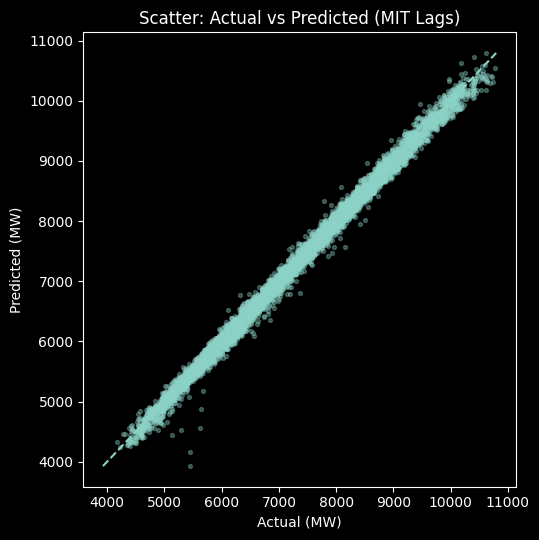

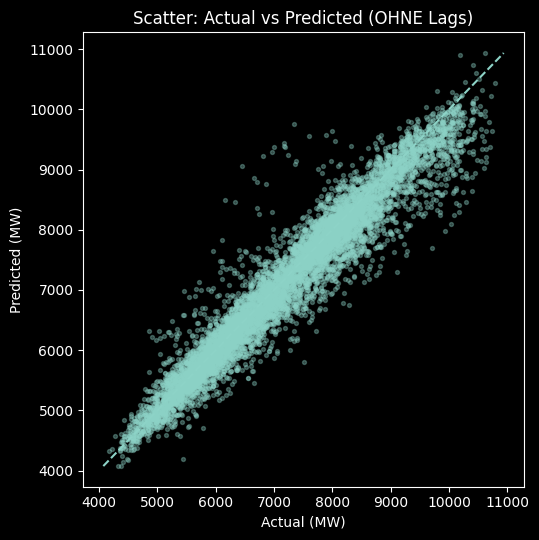

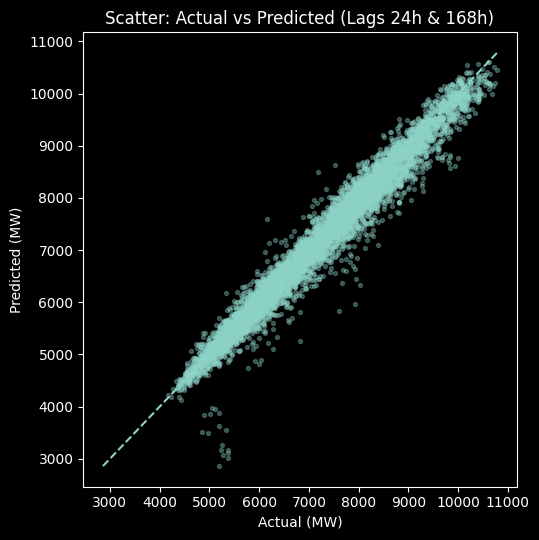

In [16]:
pdf_pred_lags = pred_to_pandas(pred_lags)
pdf_pred_nolag = pred_to_pandas(pred_nolag)
pdf_pred_lags_24_168 = pred_to_pandas(pred_lags_24_168)

plot_scatter_actual_vs_pred(pdf_pred_lags, "Scatter: Actual vs Predicted (MIT Lags)")
plot_scatter_actual_vs_pred(pdf_pred_nolag, "Scatter: Actual vs Predicted (OHNE Lags)")
plot_scatter_actual_vs_pred(pdf_pred_lags_24_168, "Scatter: Actual vs Predicted (Lags 24h & 168h)")

Bestes Modell (geringste Streuung) ist das Modell mit allen 3 Lag features.
Ohne Lags ist ie Performance deutlich geringer.
Modell mit 24h und 168h Lags ist dazwischen.
Das heißt die Lags erhöhen Genauigkeit erheblich.

Plot für feature importance (Balkendiagramme):

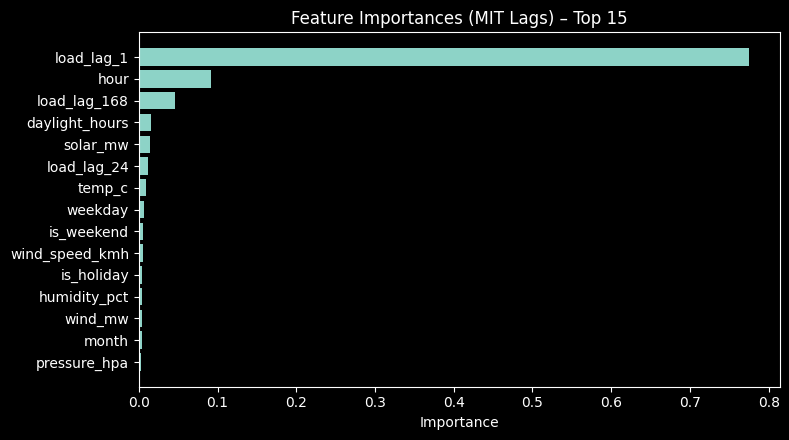

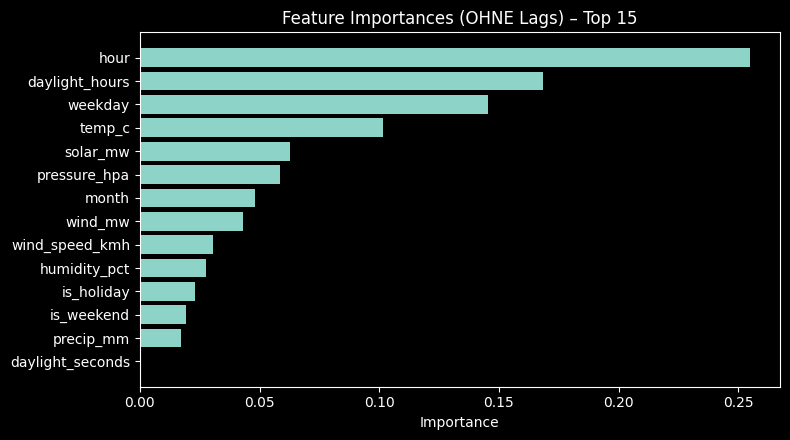

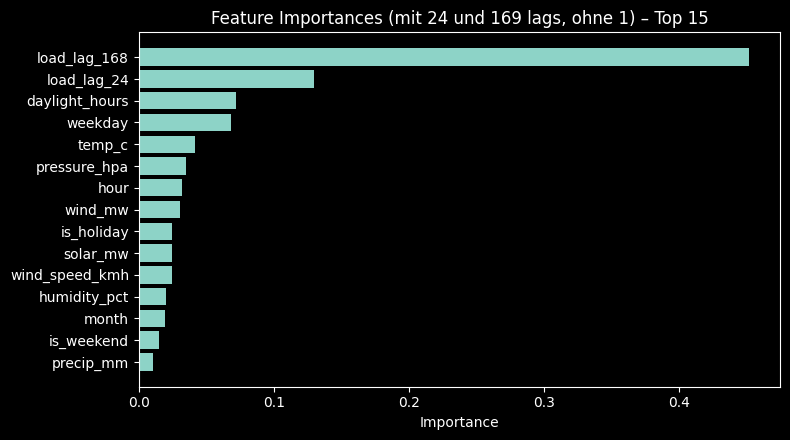

In [17]:
plot_feature_importance(imp_lags, "Feature Importances (MIT Lags) – Top 15", top_n=15)
plot_feature_importance(imp_nolag, "Feature Importances (OHNE Lags) – Top 15", top_n=15)
plot_feature_importance(imp_cols_lags_24_168, "Feature Importances (mit 24 und 169 lags, ohne 1) – Top 15", top_n=15)


Hier wird ersichtlich, wieso das Model mit Lag 1h eine bessere Performance hat -> lag 1h ist das wichtigste feature mit importance von knapp 0,8.
Hour (Stunde eines 24 Tages, z.B. 10 = 10 Uhr) -> auch wichtiges Feature, deutet auch darauf hin, dass Tagesverlauf eine große Rolle spielt.
Auch interessant: Lag 168h (1 Woche vorher) ist wichtiger als lag 24 (1 Tag vorher), d.h. es gibt auch Muster über die Woche -> z.B. Unterschied Wochenende vs. Wochentag
Unsere ursprüngliche Vermutung, dass sich die Tageslänge (Dauer zwischen Sonnenauf- und Untergang) auf den Stromverbrauch auswirkt, hat sich bestätigt: daylight_hours ist bei allen Modellen in den Top 4, daylight_seconds ist einfach die Umrechnung von daylight_hours und damit redundant (hätten wir löschen können)

Mean Average Error und Root Mean Squared Error:

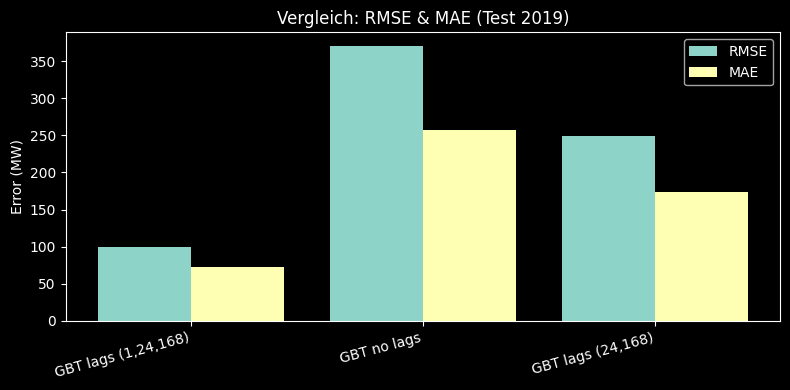

In [18]:
metrics_rows = [
    {"model": "GBT lags (1,24,168)", "rmse": rmse_lags, "mae": mae_lags},
    {"model": "GBT no lags", "rmse": rmse_nolag, "mae": mae_nolag},
    {"model": "GBT lags (24,168)", "rmse": rmse_lags_24_168, "mae": mae_lags_24_168},
]
plot_metrics_bar(metrics_rows, title="Vergleich: RMSE & MAE (Test 2019)")

Hier nochmal die Errors gegenübergestellt: RMSE = Root Mean Squared Error; MAE = Mean Average Error Bei allen 3 Modellen ist RMSE höher als MAE, was darauf hinweist, dass es Ausreißer (also ungewöhnlich große Unterschiede zwischen Vorhersage und richtigem Verbrauch) gibt. Ein Grund könnte sein, dass Features fehlen, die sich in manchen Szenarien auf den Stromverbrauch auswirken (z.B. haben wir zwar saisonale Daten, soziales Verhalten durch Wochenende und Feiertage ABER keine Daten zu Industrie (z.B. Produktion), die sich wahrscheinlich auch signifikant auf den Stromverbauch auswirktRMSE = Root Mean Squared Error; MAE = Mean Average Error
Bei allen 3 Modellen ist RMSE höher als MAE, was darauf hinweist, dass es Ausreißer (also ungewöhnlich große Unterschiede zwischen Vorhersage und richtigem Verbrauch) gibt. Ein Grund könnte sein, dass Features fehlen, die sich in manchen Szenarien auf den Stromverbrauch auswirken (z.B. haben wir zwar saisonale Daten, soziales Verhalten durch Wochenende und Feiertage ABER keine Daten zu Industrie (z.B. Produktion), die sich wahrscheinlich auch signifikant auf den Stromverbauch auswirkt

RMSE = Root Mean Squared Error; MAE = Mean Average Error Bei allen 3 Modellen ist RMSE höher als MAE, was darauf hinweist, dass es Ausreißer (also ungewöhnlich große Unterschiede zwischen Vorhersage und richtigem Verbrauch) gibt. Ein Grund könnte sein, dass Features fehlen, die sich in manchen Szenarien auf den Stromverbrauch auswirken (z.B. haben wir zwar saisonale Daten, soziales Verhalten durch Wochenende und Feiertage ABER keine Daten zu Industrie (z.B. Produktion), die sich wahrscheinlich auch signifikant auf den Stromverbauch auswirkt

Zusätzlich haben wir ein Modell trainiert, das als features statt den über Österreich gemittelten Wetterdaten, einzelne Temperaturdaten für jede Landeshauptstadt beinhaltet. Wir haben vermutet, dass wir dadurch die Genauigkeit erhöhen können (z.B. hat Wien sehr viele Einwohner, im Westen ist es hingegen meist Kälter). Diese hat sich allerdings leicht verschlechtert. Dadurch sind wir beim ursprünglichen Modell geblieben, das Mittelwerte verwendet.